# Reduced Spectral integrand for eigvec normalization

Now that we have done the theory, let's see if this works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from slab import SlabExact, plot_complex, plot_complex_surface
plt.style.use('dark_background')
%matplotlib widget

In [2]:
A = SlabExact(scale=1e-5, Ts=[6.5, 1, 8, 2.5, 6.5],
      ns=[1, 1.44, 1, 1.44, 1], xrefs=[100, 40, 300, 40, 100],
      symmetric=True, wl=6.9e-6, Shift=0)

In [3]:
def Spectral_Integrand(C, x=0, s=0):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    x_idx, s_idx = A.region_index(x), A.region_index(s)
    
    Tx = A.transmission_matrix(C, up_to_region=x_idx)
    Ts = A.transmission_matrix(C, up_to_region=s_idx)
    M = A.transmission_matrix(C)
    
    a, b, c, d = M[...,0,0], M[...,0,1], M[...,1,0], M[...,1,1]
    
    Zx, Zs = A.Zi_from_Z0(C, ni=A.ns[x_idx]), A.Zi_from_Z0(C, ni=A.ns[s_idx])
    
    ex = np.zeros(Zx.shape + (1, 2), dtype=complex)
    es = np.zeros(Zx.shape + (1, 2), dtype=complex)
    
    ex[..., 0, 0] = np.exp(1j * Zx * x)
    ex[..., 0, 1] = np.exp(-1j * Zx * x)
    
    es[..., 0, 0] = np.exp(1j * Zs * s)
    es[..., 0, 1] = np.exp(-1j * Zs * s)
    
    Ex = ex @ Tx
    Es = es @ Ts

    E, F = Ex[..., 0,0], Ex[..., 0,1]
    G, H = Es[..., 0,0], Es[..., 0,1]
    num = -E * G * b * d - F * H * a * c + (E * H + F * G) * a * d
    return 1 / (2 * np.pi) * (-E * G * b / a - F * H * c / d + E * H + F * G)

def Numerator(C, x=0, s=0):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    x_idx, s_idx = A.region_index(x), A.region_index(s)
    
    Tx = A.transmission_matrix(C, up_to_region=x_idx)
    Ts = A.transmission_matrix(C, up_to_region=s_idx)
    M = A.transmission_matrix(C)
    
    a, b, c, d = M[...,0,0], M[...,0,1], M[...,1,0], M[...,1,1]
    
    Zx, Zs = A.Zi_from_Z0(C, ni=A.ns[x_idx]), A.Zi_from_Z0(C, ni=A.ns[s_idx])
    
    ex = np.zeros(Zx.shape + (1, 2), dtype=complex)
    es = np.zeros(Zx.shape + (1, 2), dtype=complex)
    
    ex[..., 0, 0] = np.exp(1j * Zx * x)
    ex[..., 0, 1] = np.exp(-1j * Zx * x)
    
    es[..., 0, 0] = np.exp(1j * Zs * s)
    es[..., 0, 1] = np.exp(-1j * Zs * s)
    
    Ex = ex @ Tx
    Es = es @ Ts

    E, F = Ex[..., 0,0], Ex[..., 0,1]
    G, H = Es[..., 0,0], Es[..., 0,1]
    num = -E * G * b * d - F * H * a * c + (E * H + F * G) * a * d
    return 1 / (2 * np.pi) * num

In [4]:
C = 1+.1j
Eig = A.normalizer('eigvec')
Spectral_Integrand(C)[0], A.spectral_integrand(C, s=0, Normalizer=Eig)

((-0.003284035875954979+0.03259941468251633j),
 (-0.003284035876089637+0.03259941468259711j))

Okay, not working yet.

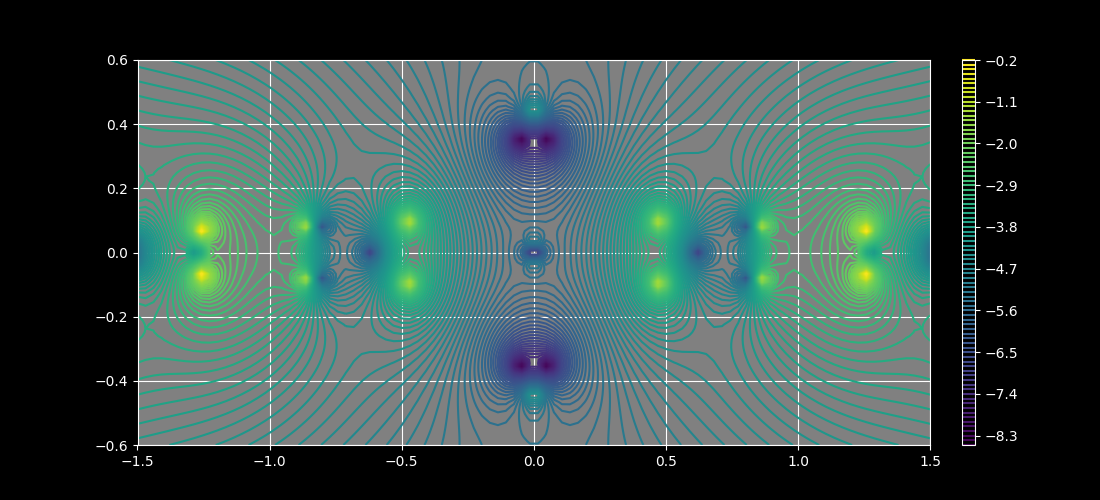

In [5]:
plot_complex(Spectral_Integrand, -1.5, 1.5, -.6, .6, fargs=(7, 0), iref=100, rref=100, levels=100)

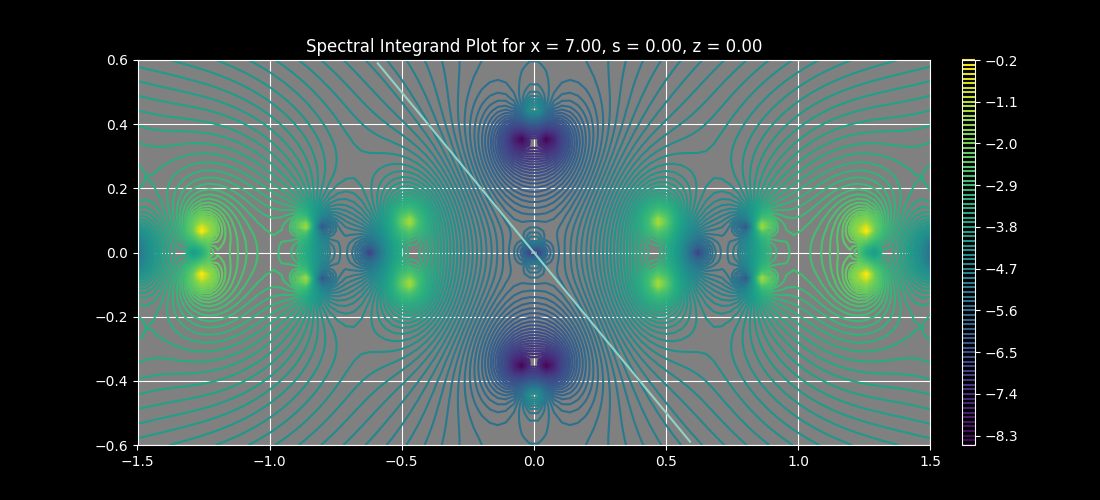

In [6]:
A.spectral_integrand_plot(-1.5, 1.5, -.6, .6, s=0, x=7, Normalizer=Eig)

In [7]:
ratio = lambda C: Spectral_Integrand(C) / A.spectral_integrand(C, s=0, x=0, z=0, Normalizer=Eig)

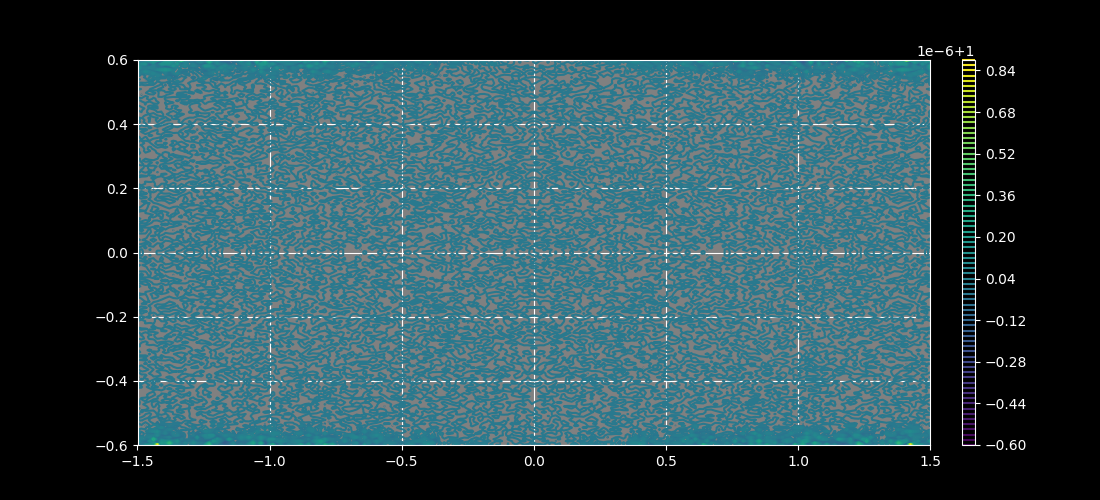

In [8]:
plot_complex(ratio, -1.5, 1.5, -.6, .6, iref=200, rref=200, levels=80, log_abs=False)

In [9]:
ratio(6+.1j)

array([1.-6.24013227e-13j])

It's correct now.  Below are the cells used for debugging.

New discovery: it's a simple sign issue somewhere in the R matrix.  I got it after changing the sign on the EH + FG part to negatives.  Still need to figure out exact issue but I almost have it.

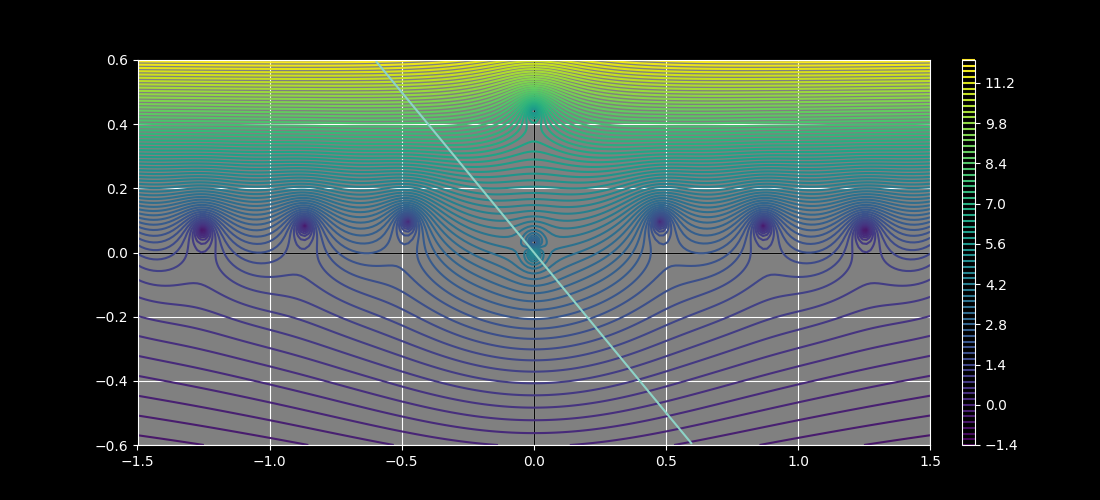

In [10]:
A.determinant_plot(-1.5, 1.5, -.6, .6, mode_type='leaky');

In [11]:
Z_leaky = newton(A.determinant, np.array(.5-.18j))[0].conj()
A.plot_points(Z_leaky)
F_leaky = A.fields(Z_leaky, mode_type='leaky')
ys_F = -F_leaky(A.all_Xs)

In [12]:
ys = np.array([Numerator(Z_leaky, x=X, s=0) for X in A.all_Xs]) / 40
ys / ys_F

array([[ 1.16178744 +2.89128647j,  1.25989724 +2.87154178j,
         1.35795845 +2.84858325j, ..., -1.70931818+64.62516153j,
        -3.71274426+64.1321135j , -5.68716417+63.57995226j],
       [ 1.06372959 +2.90783767j,  1.16178744 +2.89128647j,
         1.25989724 +2.87154178j, ..., -3.71274426+64.1321135j ,
        -5.68716417+63.57995226j, -7.63093213+62.9699845j ],
       [ 0.96582291 +2.92121874j,  1.06372959 +2.90783767j,
         1.16178744 +2.89128647j, ..., -5.68716417+63.57995226j,
        -7.63093213+62.9699845j , -9.54245424+62.3035593j ],
       ...,
       [ 0.10674946 +0.1056449j ,  0.11071109 +0.102893j  ,
         0.11460902 +0.09999987j, ...,  1.16178744 +2.89128647j,
         1.06372959 +2.90783767j,  0.96582291 +2.92121874j],
       [ 0.11071109 +0.102893j  ,  0.11460902 +0.09999987j,
         0.11843844 +0.0969667j , ...,  1.25989724 +2.87154178j,
         1.16178744 +2.89128647j,  1.06372959 +2.90783767j],
       [ 0.11460902 +0.09999987j,  0.11843844 +0.0969667j 

/home/pv/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/pv/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


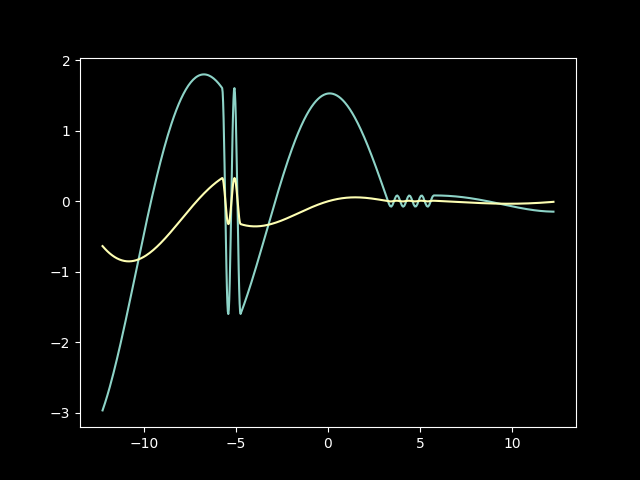

In [13]:
plt.close('all')
plt.plot(A.all_Xs, ys)
plt.plot(A.all_Xs, ys_F);

Let's debug here.  First, can we get the regional field coefficients from x right?

In [14]:
C = 1 + 1j
x = 1

try:
    len(C)
    C = np.asanyarray(C)
except TypeError:
    C = np.asanyarray([C])

x_idx = A.region_index(x)

Tx = A.transmission_matrix(C, up_to_region=x_idx)

BC = Eig.normalization(C)
Coeffs = A.coefficients(C, mode_type='radiation', Normalizer=Eig, rounding=16, sign=1)

reg_coeffs = Coeffs.T[x_idx]
our_coeffs = (Tx @ BC)[0].T[0]

our_coeffs, reg_coeffs

(array([-4.25521599e-07+6.12990105e-07j, -2.80965106e-03-3.31315280e-03j]),
 array([-4.25521599e-07+6.12990106e-07j, -2.80965106e-03-3.31315280e-03j]))

Okay the coefficient part seems good for a single Z value. Let's see if the vectorized version of getting the fields is good for a single Z value.

In [15]:
Zx = A.Zi_from_Z0(C, ni=A.ns[x_idx])
ex = np.array([np.exp(1j * Zx * x).T, np.exp(-1j * Zx * x).T]).T

Ex = ex[...,np.newaxis,:] @ Tx

x_vals = Ex @ BC
x_vals

array([[[-0.01170515+0.00156065j]]])

In [16]:
A.evaluate_fields(C, x=x, Normalizer=Eig)

array([-0.01170515+0.00156065j])

Okay, the evaluate fields part seems okay too now, after I realized I was entering the wrong x value in the built-in function.  This was all for a single Z value though, time to check for an array of Z values.

In [17]:
C = np.array([1 + .1j, 2 + .1j])

x_idx = A.region_index(x)
Tx = A.transmission_matrix(C, up_to_region=x_idx)
our_coeffs = Tx @ Eig.normalization(C)

built_in_coeffs = A.coefficients(C, up_to_region=x_idx, mode_type='radiation', Normalizer=Eig)

our_coeffs, built_in_coeffs[..., x_idx]

(array([[[-0.02313379+0.03320284j],
         [-0.04391955-0.02753678j]],
 
        [[ 0.44682111-0.19301643j],
         [-0.34795479-0.04594476j]]]),
 array([[-0.02313379+0.03320284j, -0.04391955-0.02753678j],
        [ 0.44682111-0.19301643j, -0.34795479-0.04594476j]]))

Okay the coefficient part seems good for arrays of Z values.  Let's check the field values we get.

In [18]:
Zx = A.Zi_from_Z0(C, ni=A.ns[x_idx])
ex = np.zeros(Zx.shape + (1, 2), dtype=complex)

ex[..., 0, 0] = np.exp(1j * Zx * x)
ex[..., 0, 1] = np.exp(-1j * Zx * x)

Ex = ex @ our_coeffs

Ex

array([[[-0.08842412+0.02301935j]],

       [[ 0.10441691+0.81110927j]]])

In [19]:
A.evaluate_fields(C, x=x, Normalizer=Eig)

array([-0.08842412+0.02301935j,  0.10441691+0.81110927j])

Okay that seems good too.  